In [5]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

[yfinance documentation](https://pypi.org/project/yfinance/)

[Geeks for Geeks Tutorial](https://www.geeksforgeeks.org/get-financial-data-from-yahoo-finance-with-python/)

### Canada Oil and Gas

In [6]:
suncor_t = yf.Ticker('SU')
enbridge_t = yf.Ticker('ENB')
cenovus_t = yf.Ticker('CVE')


### Canada Tech


In [7]:
shopify_t = yf.Ticker('SHOP')
constsoft_t = yf.Ticker('CSU')
nuvei_t = yf.Ticker('NVEI')


In [8]:
### Get the ticker stock history in a dataframe ###
### Input the start and end dates and stock symbol ###
def get_tick_hist_df(start, end, symbol):
    
    ticker = yf.Ticker(symbol)
    df = ticker.history(start=start, end=end)
    df.title = symbol
    return df

In [9]:
suncor_df = get_tick_hist_df("2020-04-01", "2022-04-01", 'SU')
enbridge_df = get_tick_hist_df("2020-04-01", "2022-04-01", 'ENB')
cenovus_df = get_tick_hist_df("2020-04-01", "2022-04-01", 'CVE')


In [10]:
shopify_df = get_tick_hist_df("2020-04-01", "2022-04-01", 'SHOP')
nvidia_df = get_tick_hist_df("2020-04-01", "2022-04-01", 'NVDA')
c3_df = get_tick_hist_df("2020-04-01", "2022-04-01", 'AI')

In [11]:
def plot_col(df,column):
    df[column].to_frame().plot()


<AxesSubplot:xlabel='Date'>

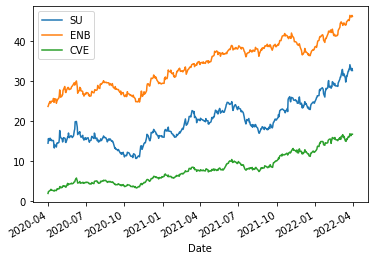

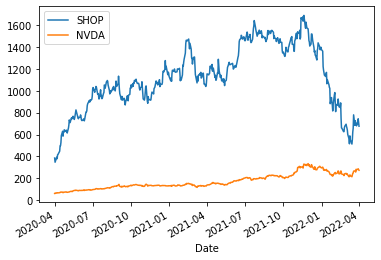

In [12]:
# Plot multiple stocks together in same plot
# Inputs are a list of stock history dataframes and the column to plot #

def plot_mult_dfs(dfs, column):
    data = {}
    for df in dfs:
        data[df.title] = df[column].values
    while True:
        try: 
            index = dfs[0].index
            new_df = pd.DataFrame(data, index=index)
            return new_df.plot()
        except ValueError:
            print("Length of data doesn't match")
            return

    
plot_mult_dfs([suncor_df, enbridge_df, cenovus_df], 'Close')
plot_mult_dfs([shopify_df, nvidia_df], 'Close')


In [13]:
# Create list of stocks to then plot against eachother 
# Input start and end date for stock history
# List of stock symbols
# Column to ploth - usually 'Close' which is the closing price

def plot_shares(start, end, stocks, column):
    dfs = []
    for stock in stocks:
        df = get_tick_hist_df(start, end, stock)
        dfs.append(df)
    plot_mult_dfs(dfs, column)

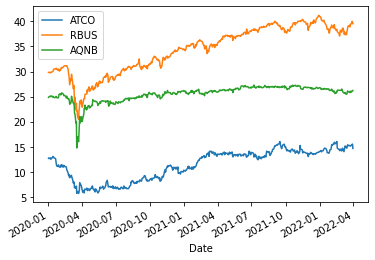

In [14]:
rand_stocks = ['ATCO', 'RBUS', 'AQNB']
plot_shares("2020-01-01", "2022-04-01", rand_stocks, 'Close')


In [15]:
# plot_col(suncor_df,'Close')
# plot_col(enbridge_df, 'Close')
# plot_col(cenovus_df, 'Close')

### Check stocks trend using differencing method from lecture 2.3

In [20]:
def plot_difference(start, end, stocks, column):
    for stock in stocks:
        df = get_tick_hist_df(start, end, stock)
        df_prices = df[column].to_frame()
        df_prices['Differences'] = df_prices[column] - df_prices[column].shift()
        df_prices.plot()

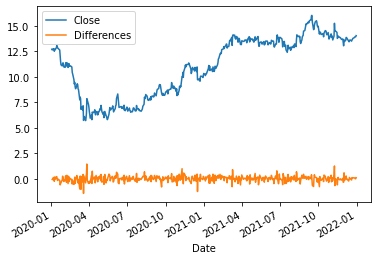

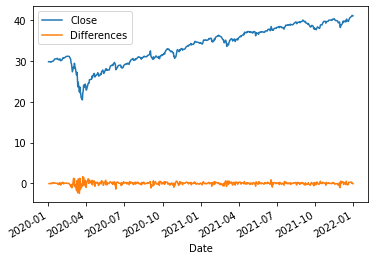

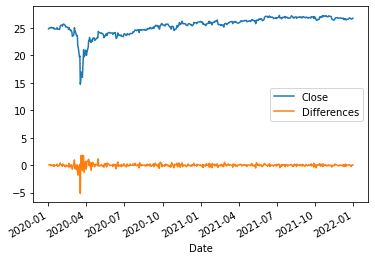

In [21]:
plot_difference('2020-01-01', '2022-01-01', rand_stocks, 'Close')

## Seasonality

Check atco for seasonality

In [25]:
df_atco = get_tick_hist_df('2010-01-01', '2022-01-01', 'ATCO')
df_atco_price = df_atco['Close'].to_frame()
df_atco_price.head()

,Close
Date,
2010-01-04,4.599852
2010-01-05,4.652613
2010-01-06,4.719764
2010-01-07,4.700578
2010-01-08,4.930812


<AxesSubplot:xlabel='Date'>

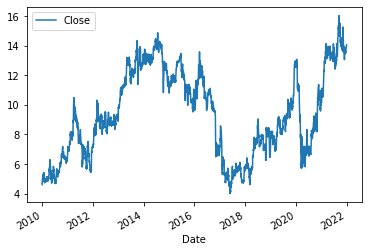

In [26]:
df_atco_price.plot()

In [37]:
def get_season_means(df, column, num_seasons):
    season_sum = [0]*num_seasons
    season_count = [0]*num_seasons
    season_mean = [0]*num_seasons
    # use running totals to get monthly sum and monthly count
    for i, value in enumerate(df[column]):
        season_sum[i % num_seasons] += df[column][i]
        season_count[i % num_seasons] += 1
    # calculate monthly avg
    for i in range(num_seasons):
        season_mean[i] = season_sum[i] / season_count[i]
    return season_mean

atco_month_mean = get_season_means(df_atco_price, 'Close', 4)
print(atco_month_mean)

[9.385415990516622, 9.390449628135226, 9.380766902064645, 9.383620308882353]


In [38]:
import numpy as np

def get_overall_mean(df, column):
    mean = np.mean(df[column].values)
    return mean

atco_overall_mean = get_overall_mean(df_atco_price, 'Close')
print(atco_overall_mean)

9.385063324176645


In [40]:
def get_season_offsets(mean, season_means, num_seasons):
    season_offsets = [0]*num_seasons
    for i in range(num_seasons):
        season_offsets[i] = season_means[i] - mean
    return season_offsets


In [44]:
atco_seasonal_offsets = get_season_offsets(atco_overall_mean, atco_month_mean, 4)
print(atco_seasonal_offsets)

[0.00035266633997643737, 0.0053863039585806405, -0.004296422112000542, -0.0014430152942921382]


#### Calculate new adjusted values and create column in dataframe

In [71]:
def get_seasonally_adj_df(df, column, offsets):
    seasonally_adj = []
    num_seasons = len(offsets)
    for i, val in enumerate(df[column]):
        seasonally_adj.append( val - offsets[i % num_seasons])
    df.insert(1, 'Seasonally Adjusted', seasonally_adj)
    return df


In [48]:
atco_adjusted_df = get_seasonally_adj_df(df_atco_price, 'Close', atco_seasonal_offsets)
atco_adjusted_df.head()

ValueError: cannot insert Seasonally Adjusted, already exists

<AxesSubplot:xlabel='Date'>

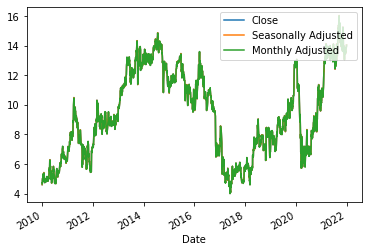

In [46]:
atco_adjusted_df.plot()

In [94]:
def get_seasonally_adjuted_stock_data(start, end, symbol, num_seasons):
    df = get_tick_hist_df(start, end, symbol)
    df_price = df['Close'].to_frame()
    seasonal_means = get_season_means(df_price, 'Close', num_seasons)
    overall_mean = get_overall_mean(df_price, 'Close')
    seasonal_offsets = get_season_offsets(overall_mean, seasonal_means, num_seasons)
    print(seasonal_offsets)
    adjusted_df = get_seasonally_adj_df(df_price, 'Close', seasonal_offsets)
    return adjusted_df

    

[0.023300315506681102, -0.0026426504095411474, -4.309089808884892e-05, -0.04568491309740352, -0.06550294138581592, -0.09491116412145573, -0.02266957672159009, 0.03301153356034803, 0.03213474496806157, -0.015311967990150777, 0.05051827865524672, 0.10775223247260612]


<AxesSubplot:xlabel='Date'>

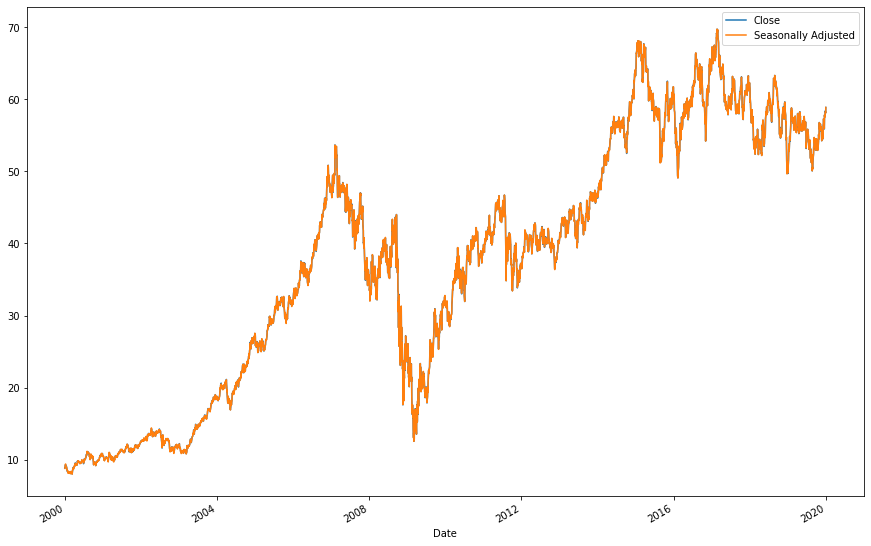

In [96]:
df_adj = get_seasonally_adjuted_stock_data('2000-01-01','2020-01-01','VNO', 12)
# atco_adj['Seasonally Adjusted'].plot()
df_adj.plot(figsize=(15,10))